<a href="https://colab.research.google.com/github/Yufanzh/time_series_analysis/blob/main/SARMAX_for_hospitalityemployee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# import specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # for determining (p, q) orders
from statsmodels.tsa.seasonal import seasonal_decompose # for ETS plots

%pip install pmdarima
from pmdarima import auto_arima

# import evaluation tools
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error

In [2]:
# Loading dataset
df = pd.read_csv('./HospitalityEmployees.csv', index_col='Date', parse_dates=True)
df.index.freq = 'MS'
print('data frame row no#: ', len(df))
print(df.head())

data frame row no#:  348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


## 1. Plot the source data
Creat a line chart of the dataset. Optional: add a title and y-axis label

<Axes: title={'center': 'California Hospitality Industry Employees'}, xlabel='Date', ylabel='Thousands of Persons'>

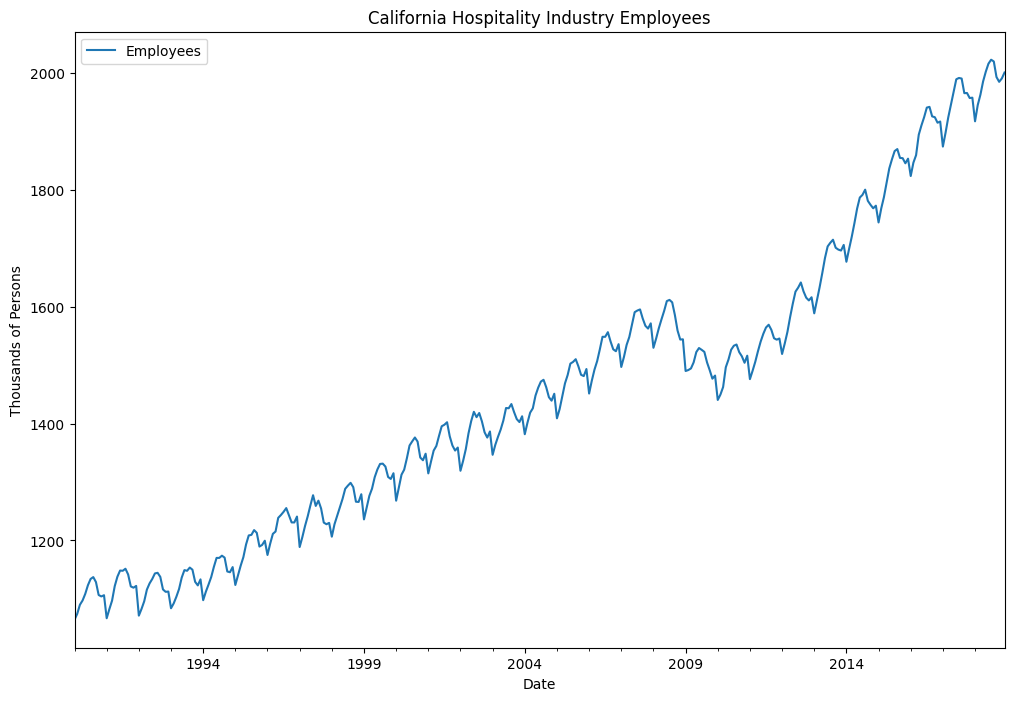

In [3]:
df.plot(figsize=(12,8), title='California Hospitality Industry Employees', ylabel='Thousands of Persons')

## 2. Run an ETS Decomposition
Use an 'additive' model

In [5]:
seasonal = seasonal_decompose(df['Employees'],model='additive')

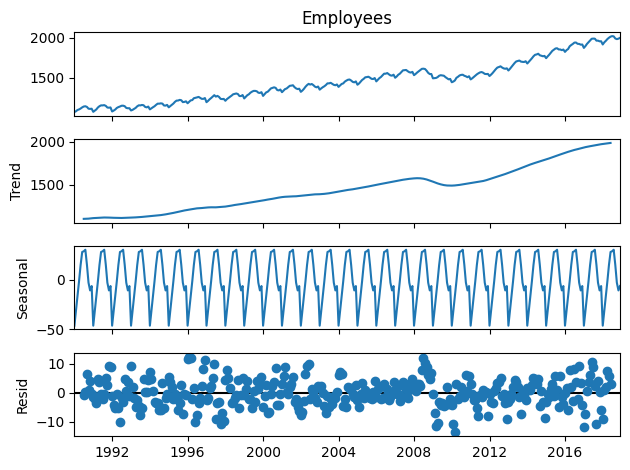

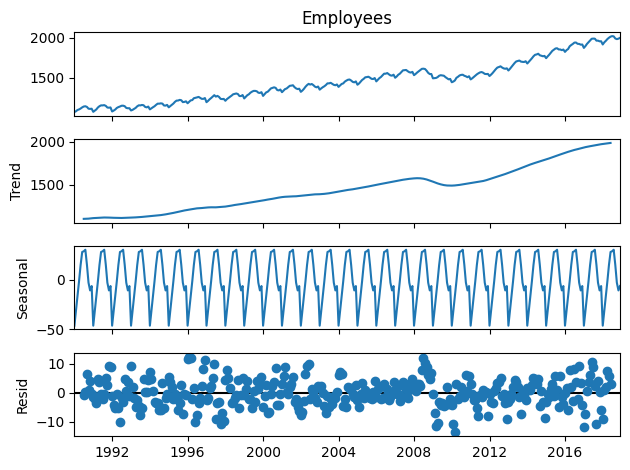

In [10]:
seasonal.plot(seasonal=True)

<Axes: xlabel='Date'>

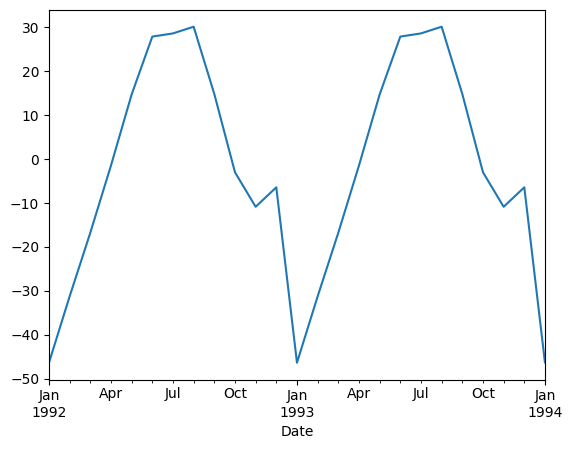

In [15]:
seasonal.seasonal.plot(xlim=['1992-01-01', '1994-01-01'])

## 3. Run auto_arima to obtain recommended order


In [17]:
auto_arima(df['Employees'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Fri, 15 Mar 2024   AIC                           2208.504
Time:                                      16:07:02   BIC                           2231.600
Sample:                                  01-01-1990   HQIC                          2217.700
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9244      0.045     20.511      0.000       0.836       1.013
ma.L1         -0.9440      0.070    -13.539      0.000      -1.081      -0.807
ma.L2          0.1288      0.060      2.155      0.031       0.012       0.246
ar.S.L12       0.9972      0.001    701.980      0.000       0.994       1.000
ma.S.L12      -0.7490      0.043    -17.333      0.000      -0.834      -0.664
sigma2        29.2994      1.717     17.061      0.000      25.933      32.665
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 4. Split the data into training and testing sets
Based on the auto_arima test, the recommended ARIMA order is (1,1,2) and the seasonal order is (1,0,1,12)

We can set the testing sets to be 12 months, based on the seasonality

In [18]:
noobs = 12
train = df.iloc[:-noobs]
test = df.iloc[-noobs:]

## 5. Fit a SARIMA(1,1,2)X(1,0,1,12) model to training set

In [19]:
model = SARIMAX(train['Employees'], order=(1,1,2), seasonal_order=(1, 0, 1, 12))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1058.058
Date:                              Fri, 15 Mar 2024   AIC                           2128.116
Time:                                      16:12:04   BIC                           2151.001
Sample:                                  01-01-1990   HQIC                          2137.240
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9241      0.043     21.254      0.000       0.839       1.009
ma.L1         -0.9584      0.070    -13.646      0.000      -1.096      -0.821
ma.L2          0.1497      0.061      2.462      0.014       0.031       0.269
ar.S.L12       0.9973      0.001    727.106      0.000       0.995       1.000
ma.S.L12      -0.7518      0.044    -17.149      0.000      -0.838      -0.666
sigma2        28.7654      1.684     17.080      0.000      25.465      32.066
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.34
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 6. Obtain predicted values

In [20]:
start = len(train)
end = len(train) + len(test) - 1
predictions = res.predict(start, end, dynamic=False, type='levels').rename('SARIMAX(1,1,2)x(1,0,1,12) predictions')

## 7. Plot preductions agains test values

<Axes: xlabel='Date'>

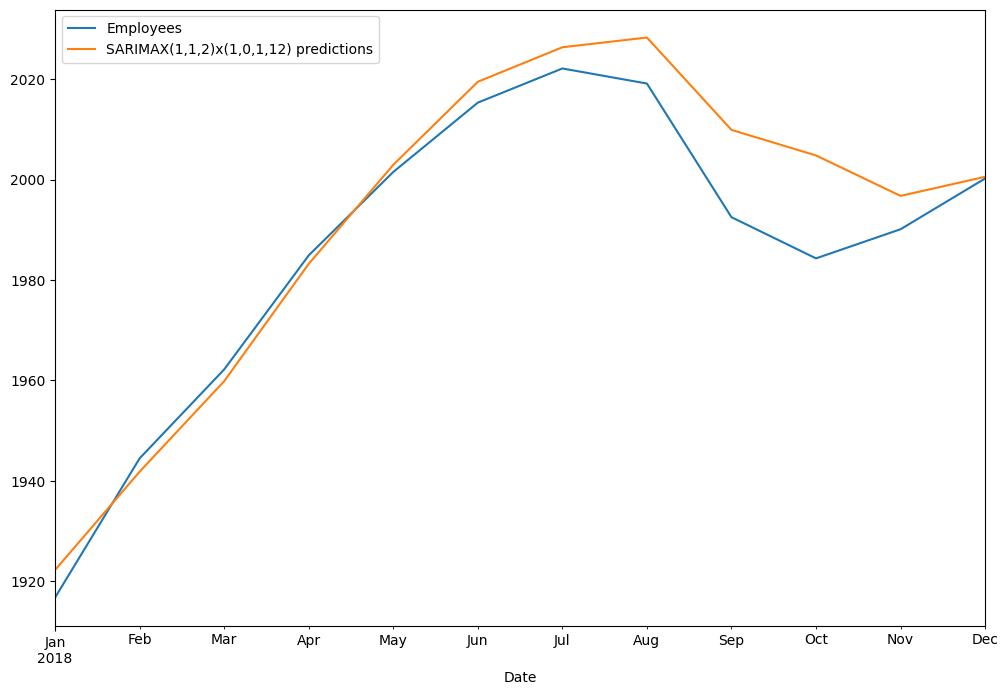

In [21]:
test['Employees'].plot(figsize=(12,8), legend=True)
predictions.plot(legend=True)

## 8. Evaluate the Model using MSE and RMSE

In [23]:
mse = mean_squared_error(test['Employees'], predictions)
rmse = rmse(test['Employees'], predictions)

In [25]:
print(f'mean squared error is {mse}')
print(f'root mean squared error is {rmse}')

mean squared error is 77.6912147264906
root mean squared error is 8.8142620069119


In [26]:
test['Employees'].mean()

1986.125

## 9. Retrain the model on the full dataset and forcast one year into the future

current model error looks reasonable. Let's use it for predictions!

In [27]:
model_full = SARIMAX(df['Employees'], order = (1,1,2), seasonal_order = (1,0,1,12))
res_full = model_full.fit()
res_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Fri, 15 Mar 2024   AIC                           2208.504
Time:                                      16:20:50   BIC                           2231.600
Sample:                                  01-01-1990   HQIC                          2217.700
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9244      0.045     20.511      0.000       0.836       1.013
ma.L1         -0.9440      0.070    -13.539      0.000      -1.081      -0.807
ma.L2          0.1288      0.060      2.155      0.031       0.012       0.246
ar.S.L12       0.9972      0.001    701.980      0.000       0.994       1.000
ma.S.L12      -0.7490      0.043    -17.333      0.000      -0.834      -0.664
sigma2        29.2994      1.717     17.061      0.000      25.933      32.665
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
start = len(df)
end = start + 12
predictions_full = res_full.predict(start, end, dynamic=False, type='levels').rename('forecast in the future 12month')

## 10. Plot the forecasted alongside the original data

[Text(0.5, 0, ''), Text(0, 0.5, 'Thousands of Persons')]

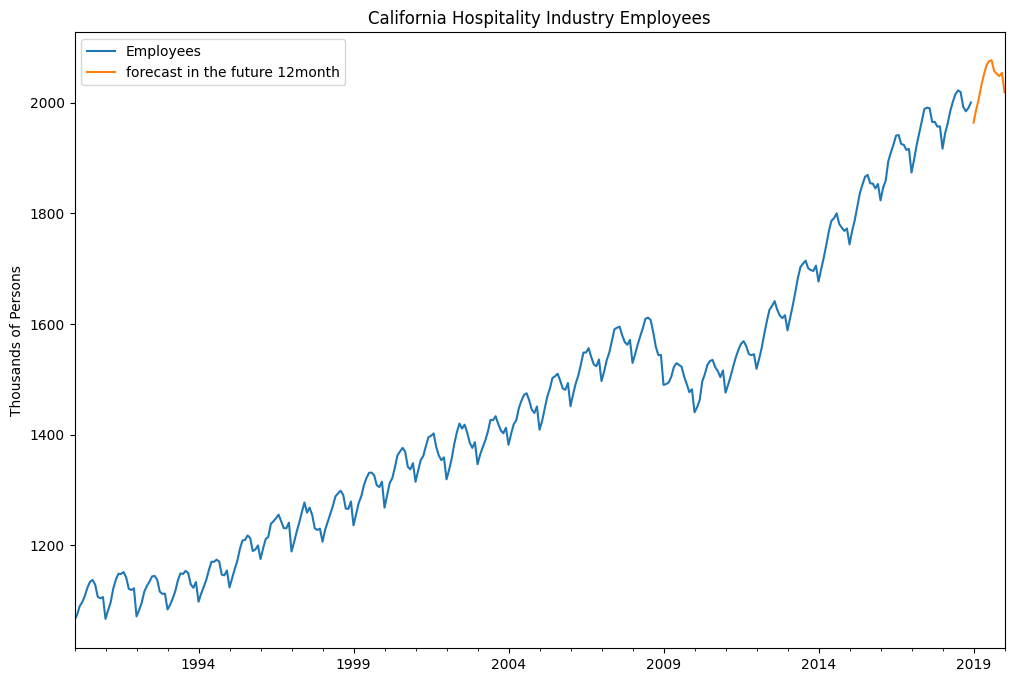

In [31]:
title = 'California Hospitality Industry Employees'
y_label = 'Thousands of Persons'
x_label = ''
ax = df['Employees'].plot(figsize=(12,8),title=title, legend=True)
predictions_full.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=x_label, ylabel=y_label)